
# Image denoising using PCA

## Load the dataset via OpenML

The USPS digits datasets is available in OpenML. We use
:func:`~sklearn.datasets.fetch_openml` to get this dataset. In addition, we
normalize the dataset such that all pixel values are in the range (0, 1).



In [10]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

The idea will be to learn a PCA basis on
noisy images and then use these models to reconstruct and denoise these
images.

Thus, we split our dataset into a training and testing set composed of 1,000
samples for the training and 100 samples for testing. These images are
noise-free and we will use them to evaluate the efficiency of the denoising
approaches. In addition, we create a copy of the original dataset and add a
Gaussian noise.

The idea of this application, is to show that we can denoise corrupted images
by learning a PCA basis on some uncorrupted images.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

In addition, we will create a helper function to qualitatively assess the
image reconstruction by plotting the test images.



In [12]:
import matplotlib.pyplot as plt


def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

In addition, we will use the mean squared error (MSE) to quantitatively
assess the image reconstruction.

Let's first have a look to see the difference between noise-free and noisy
images. We will check the test set in this regard.



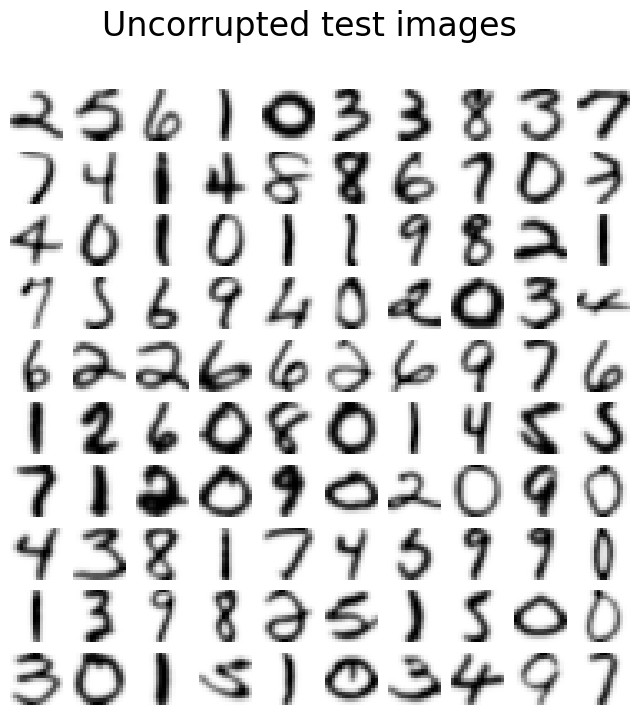

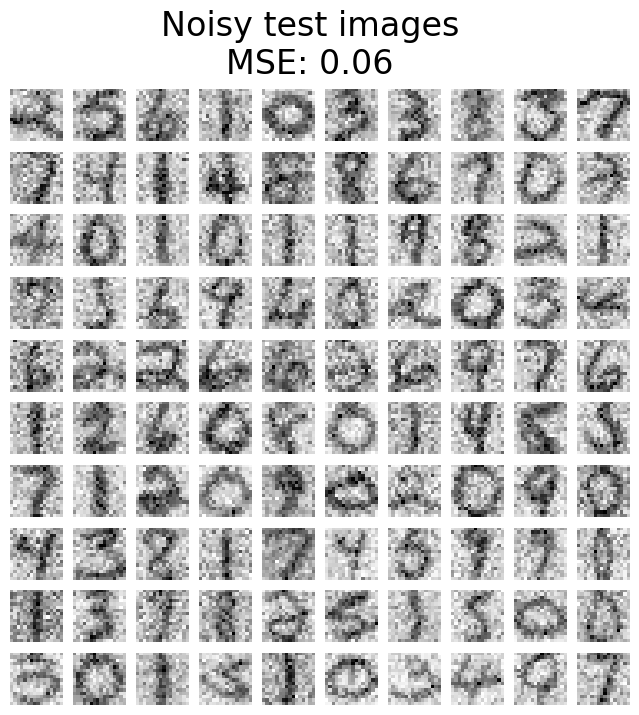

In [13]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(
    X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

## PCA function



In [14]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32, random_state=42)

pca.fit(X_train_noisy)

PCA(n_components=32, random_state=42)

## Reconstruct and denoise test images

Now, we can transform and reconstruct the noisy test set. Since we used less
components than the number of original features, we will get an approximation
of the original set. Indeed, by dropping the components explaining variance
in PCA the least, we hope to remove noise.


In [15]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

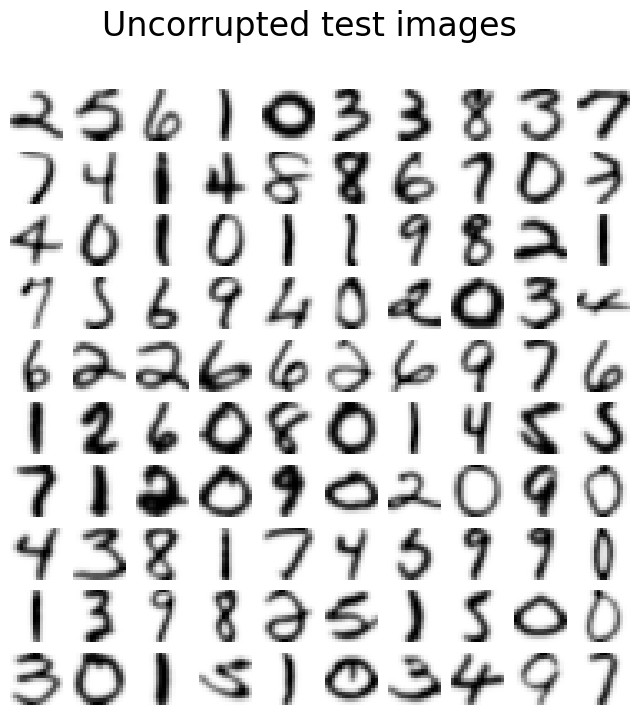

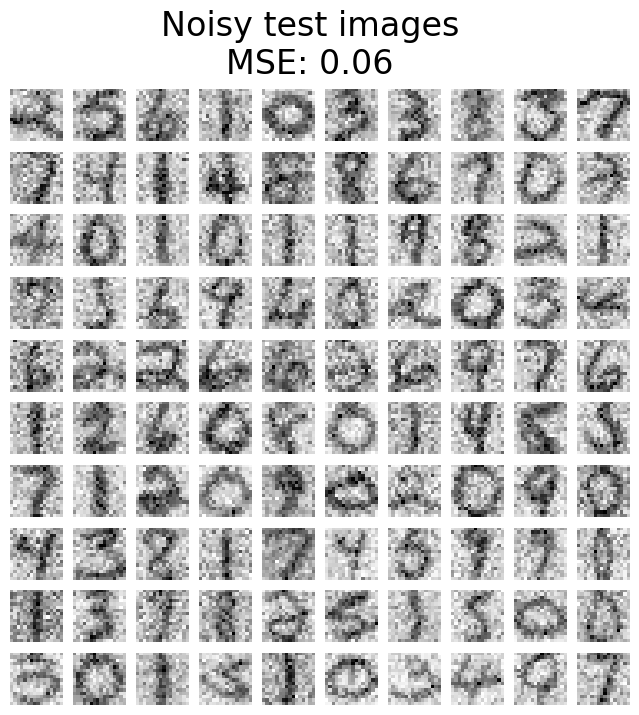

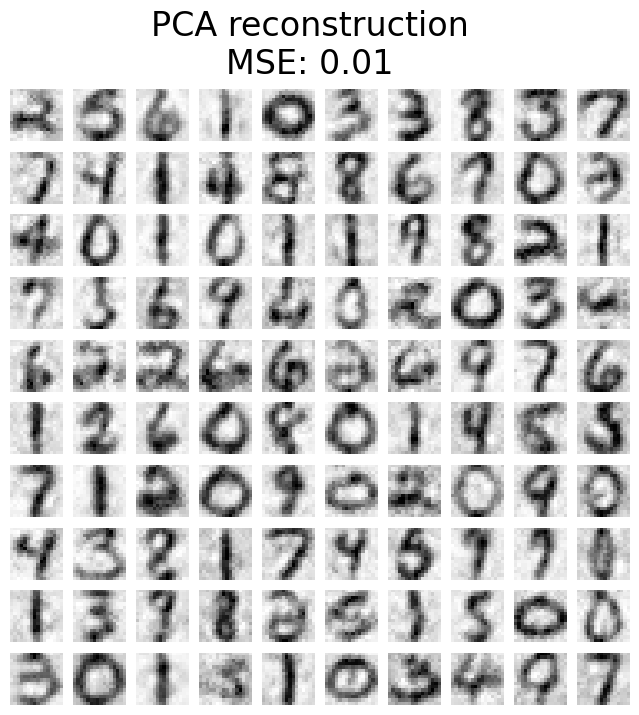

In [17]:
plot_digits(X_test, "Uncorrupted test images")
plot_digits(X_test_noisy, f"Noisy test images\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}")
plot_digits(
    X_reconstructed_pca,
    f"PCA reconstruction\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)